In [1]:
import optuna
from optuna import Trial

from math import sqrt
from typing import Tuple, List

import numpy as np
import pandas as pd
from mordred import Calculator, descriptors
#import openbabel
from openbabel import pybel
from PyBioMed.PyMolecule.fingerprint import CalculatePubChemFingerprint,CalculateECFP2Fingerprint
from rdkit import Chem
from rdkit.Chem.rdchem import Atom
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as G_Loader 
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import BatchNorm


# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch

import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
import torch.nn.functional as F # activation function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as V_Loader # dataset management
%run ./graph_feature.ipynb 
%run ./dataset_processing.ipynb 

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_idx = np.load('train_indices.npy')
val_idx = np.load('val_indices.npy')
test_idx = np.load('test_indices.npy')

In [3]:
k=10
final_clean_fingerp_train=[]
final_clean_fingerp_val=[]
for i in range(k):
    final_clean_fingerp_train.append(np.load('final_clean_fingerp_train'+ str(i)+'.npy'))
    final_clean_fingerp_val.append(np.load('final_clean_fingerp_val' +str(i)+'.npy'))

final_clean_fingerp_test = np.load('final_clean_fingerp_test.npy')

In [4]:
# load the output label 
total_train_targets =[]
total_validation_targets =[]
total_test_targets=[]
for i in range(k):
    total_train_targets.append(np.load('total_train_targets'+ str(i)+'.npy'))
    total_validation_targets.append(np.load('total_validation_targets' +str(i)+'.npy'))

total_test_targets= np.load('total_test_targets.npy')

In [5]:
# create dataloader for training (vector data)
#======================================================================================
list_data_fingerp_train =[]
list_data_fingerp_val =[]
list_data_target_train =[]
list_data_target_val =[]

for data_train, data_val, tr_targets, val_targets in zip(final_clean_fingerp_train, final_clean_fingerp_val,total_train_targets, total_validation_targets):
    train_loader = V_Loader(dataset = data_train, batch_size = 500)
    val_loader = V_Loader(dataset = data_val, batch_size = 500)
    
    tr_target_loader = V_Loader(dataset = tr_targets, batch_size = 500)
    val_target_loader =  V_Loader(dataset = val_targets, batch_size = 500)
    
    list_data_fingerp_train.append(train_loader)
    list_data_fingerp_val.append(val_loader)
    
    list_data_target_train.append(tr_target_loader)
    list_data_target_val.append(val_target_loader)

In [6]:
my_hyper_fingerp = {'optimizer_type': 3,
                    'dense_layer1': 116,
                    'dropout_rateB1': 0.19140697875883203,
                    'dropout_rateB2': 0.4378593600513469,
                    'learning_rate': 0.0005085512117234079}

In [7]:
# the model 
#==================================================================================
class modelB1(torch.nn.Module):
    def __init__(self, input_features, output_features,dropout_rateB1,dropout_rateB2, dense_layer1):
        super(modelB1, self).__init__()
        self.lin1 = nn.Linear(input_features,dense_layer1)
      
        self.lin2 = nn.Linear(int(dense_layer1), int(dense_layer1/2))
        self.lin3 = nn.Linear(int(dense_layer1/2), int(dense_layer1/2))
        self.lin4 = nn.Linear(int(dense_layer1/2), output_features)
        
        self.bn1 = nn.BatchNorm1d(int(dense_layer1))
        self.bn2 = nn.BatchNorm1d(int(dense_layer1/2))
        self.bn3 = nn.BatchNorm1d(int(dense_layer1/2))
        self.dropoutB1 = dropout_rateB1
        self.dropoutB2 = dropout_rateB2
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
       
        x = F.dropout(x, p= self.dropoutB1, training=self.training)
        x = x.relu()
  #      
        x = self.lin2(x)
        x = self.bn2(x)   
        x = F.dropout(x, p= self.dropoutB2, training=self.training)
        x = x.relu()
  #      
        x = self.lin3(x)
        x = self.bn3(x)   
        x = x.relu()
        x = self.lin4(x)
        return torch.sigmoid(x)

In [8]:
# load the best model 
#============================================================
k=10
input_features  =36
output_features =1
list_modelC =[]
for i in range(k):
    optimizer_type =my_hyper_fingerp['optimizer_type']   
    dropout_rateB1 = my_hyper_fingerp['dropout_rateB1']
    dropout_rateB2 = my_hyper_fingerp['dropout_rateB2']
    #learning_rate = my_hyper_fingerp['learning_rate']
    dense_layer1 =my_hyper_fingerp['dense_layer1']    
    
    modelC= modelB1(input_features, output_features,dropout_rateB1,dropout_rateB2, dense_layer1)
    PATH = 'model_Dense_fingerp'+ str(i)+'.pth'
    modelC.load_state_dict(torch.load(PATH))
    list_modelC.append(modelC)

In [9]:
#criterion = torch.nn.CrossEntropyLoss()
#define the loss function 
criterion = torch.nn.BCELoss()

def get_optimizer(gnn_model, learning_rate, optimizer_type,decay=1e-4):
    if optimizer_type==1:
        optimizer = torch.optim.SGD(gnn_model.parameters(), lr=learning_rate, momentum=0.9)
    if optimizer_type==2:
        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=learning_rate, weight_decay =decay)
    if optimizer_type ==3 :
        optimizer = torch.optim.Adamax(gnn_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
        
    return optimizer

In [10]:
def train_1(train_v_loaderB,tr_target_v_loaderB, combined_model, optimizer):
    combined_model.train()
    
    for data_X2, data_target in zip(train_v_loaderB, tr_target_v_loaderB):  # Iterate in batches over the training dataset.
        out = combined_model(torch.tensor(data_X2, dtype=torch.float32))  # Perform a single forward pass.
        
        y_t = torch.tensor(data_target, dtype=torch.float32)
        loss = criterion(out[:,0], y_t)  # Compute the loss.
        #print(k)
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss, combined_model, optimizer

def validation_1(val_v_loaderB,val_target_v_loaderB, combined_model):
    for data_X2, data_target in zip(val_v_loaderB, val_target_v_loaderB): # Iterate in batches over the training dataset.
        out = combined_model(torch.tensor(data_X2, dtype=torch.float32))  # Perform a single forward pass.
        
        y_t = torch.tensor(data_target, dtype=torch.float32)
        val_loss = criterion(out[:,0], y_t)  # Compute the loss.
        
    return val_loss

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, roc_curve, auc 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# performances visualization 
import matplotlib.pyplot as plt
#import seaborn as sns
import statistics
from prettytable import PrettyTable
%run ./my_performances.ipynb 


def test_1(v_loaderB,v_target, combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X2, data_target in zip (v_loaderB,v_target):  # Iterate in batches over the training/test dataset.
            out = combined_model(torch.tensor(data_X2, dtype=torch.float32))
            out_1 = out[:,0]
            
            
            list_pred.append(out_1.item())
            list_targets.append(data_target.item())
    return list_pred, list_targets 

def test_2(v_loaderB,v_target, combined_model):
    combined_model.eval()
    list_pred =[]
    list_targets =[]
    correct = 0
    for data_X2, data_target in zip (v_loaderB,v_target):  # Iterate in batches over the training/test dataset.
            out = combined_model(torch.tensor(data_X2, dtype=torch.float32))
            out_1 = out[:,0]
            
            
            #list_pred.append(out_1.item())
            #list_targets.append(data_target.item())
            
            list_pred = list_pred + out_1.tolist()
            list_targets= list_targets + data_target.tolist()
 #   print(len(list_pred))
    return list_pred, list_targets 

# used to count the train accuracy ,and validation accuracy when in the training mode 
def test(v_loaderB,target_v_loaderB, combined_model):
    combined_model.eval()

    correct = 0
    for data_X2, data_target in zip(v_loaderB,target_v_loaderB):  # Iterate in batches over the training/test dataset.
            out = combined_model(torch.tensor(data_X2, dtype=torch.float32))
            out_1 = out[:,0]
            for i,value in enumerate(out_1) :
                if value > 0.5 :
                    out_1[i] = 1
                else : out_1[i] = 0
            pred = out_1  # Use the class with highest probability.
            correct += int((pred == data_target).sum())  # Check against ground-truth labels.
    return correct / len(v_loaderB.dataset)  # Derive ratio of correct predictions.

In [12]:
k=10 # number of fold 

# for data vector 
input_features  = 36 # length of feature data vector 
output_features   = 1
    #output_featuresB   = trial.suggest_int('output_featuresB',16,9, step=1) 
optimizer_type =my_hyper_fingerp['optimizer_type']   
dropout_rateB1 = my_hyper_fingerp['dropout_rateB1']
dropout_rateB2 = my_hyper_fingerp['dropout_rateB2']
learning_rate = my_hyper_fingerp['learning_rate']
dense_layer1 =my_hyper_fingerp['dense_layer1']    

In [13]:
# APPLY THE HYPERPARAMETER 
# RUNNING EVERY FOLD 
#=============================================================

total_history_train_loss=[]
total_history_val_loss=[]
total_history_train_acc=[]
total_history_val_acc=[]
list_trained_model =[]

for i in range(k):
        
        combined_model   = modelB1(input_features, output_features,dropout_rateB1,dropout_rateB1, dense_layer1)
        optimizer = get_optimizer(combined_model, learning_rate, optimizer_type)
   
        history_train_loss=[]
        history_val_loss=[]
        history_train_acc=[]
        history_val_acc=[]
        
        for epoch in range(1,500):
            
                
            train_loss,combined_model, optimizer = train_1(list_data_vec_trainB[i],list_data_target_train[i],
                                                           combined_model,optimizer)
            val_loss                             = validation_1(list_data_vec_valB[i],list_data_target_val[i],
                                                                combined_model) 
        
            train_acc                            = test(list_data_vec_trainB[i],list_data_target_train[i],combined_model)
            val_acc                              = test(list_data_vec_valB[i],list_data_target_val[i], combined_model)
        
           
            
            history_train_loss.append(train_loss.item())
            history_val_loss.append(val_loss.item())
            history_train_acc.append(train_acc)
            history_val_acc.append(val_acc)
        
            print(f'Fold: {i}')
            print(f'Epoch: {epoch:03d}, Train Loss:, {train_loss.item():.4f}')
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
            print(f'Epoch: {epoch:03d}, val Loss:, {val_loss.item():.4f}')
            print(f'Epoch: {epoch:03d}, val Acc: {val_acc:.4f}')
            print(" ")
        total_history_train_loss.append(history_train_loss)
        total_history_val_loss.append(history_val_loss)
        total_history_train_acc.append(history_train_acc)
        total_history_val_acc.append(history_val_acc)

        list_trained_model.append(combined_model)

NameError: name 'list_data_vec_trainB' is not defined

In [14]:
# RUNNING THE 10 PRETRAINED MODEL USING INDEPENDENT DATA
#======================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]
list_trained_model_1 = list_modelC

v_test_loaderB = V_Loader(dataset = final_clean_fingerp_test, batch_size = 1)
v_test_target = V_Loader(dataset = total_test_targets, batch_size = 1)

for combined_model in list_trained_model_1:  
    list_pred, list_targets = test_1(v_test_loaderB,v_test_target,combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_test = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_test[1] , total_performances_test[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.628675

In [15]:
import statistics
from prettytable import PrettyTable
perf = total_performances_test
model_title = 'Test Perf single model'
data_type ='fingerprint vector'
Create_Tables(perf, model_title, data_type)

+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|       Model Name       |     Data Type      | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Test Perf single model | fingerprint vector | 0.628 | 0.595 | 0.662 | 0.258 | 0.671 |  0.257  |  0.671  |   0.629   |
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|       Model Name       |     Data Type      | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Test Perf single model | fingerprint v

In [16]:
def plot_ROC( method, total_performances):
    i =0
    total_data_roc = total_performances[5]
    for data_roc in total_data_roc:
    # plot ROC 
        fpr,tpr = data_roc[0], data_roc[1]
        plt.plot(fpr,tpr,marker='.',linestyle='--', label=method+'_fold_'+ str(i)+ ' AUC(' +str(total_performances[4][i])+')' )
        i = i+1
# axis labels
    plt.plot([0,1],[0,1],marker='.',linestyle='--',color='k')
    plt.title('ROC Curve for ' + str(method))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
# show the legend
    plt.legend()
# show the plot
    plt.show()
    
def plot_PR(total_data_pr, method):
    i =0
    for data_pr in total_data_pr:
    # plot PR 
        prec,rec = data_pr[0], data_pr[1]
        plt.plot(rec,prec,marker='.',linestyle='--', label=method+'_fold_'+ str(i))
        i = i+1
# axis labels
    plt.plot([0,1],[1,0], marker='.',linestyle='--',color='k')
    plt.title('PR Curve for ' + str(method))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
# show the legend
    plt.legend()
# show the plot
    plt.show()

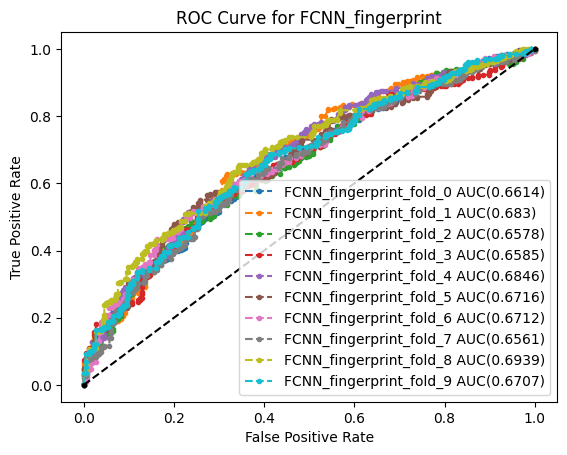

In [17]:
plot_ROC('FCNN_fingerprint', total_performances_test)

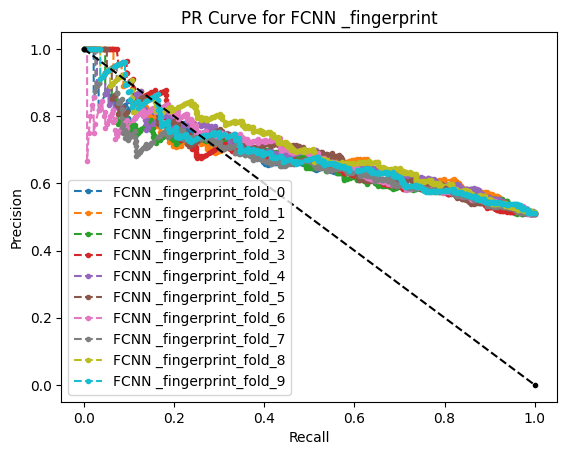

In [18]:
total_PR = total_performances_test[6]
plot_PR(total_data_pr=total_PR, method="FCNN _fingerprint")

In [19]:
# RUNNING THE 10 PRETRAINED MODEL USING INDEPENDENT DATA
#======================================================================
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]
list_trained_model_1 = list_modelC


for i,combined_model in enumerate(list_trained_model_1):  
    list_pred, list_targets = test_2(list_data_fingerp_train[i],list_data_target_train[i],combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_train = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_train[1] , total_performances_train[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.76924

In [20]:
import statistics
from prettytable import PrettyTable
perf = total_performances_train
model_title = 'Train Perf single model'
data_type ='fingerprint vector'
Create_Tables(perf, model_title, data_type)

+-------------------------+--------------------+-------+------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |     Data Type      | m_ACC | m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+-------------------------+--------------------+-------+------+-------+-------+-------+---------+---------+-----------+
| Train Perf single model | fingerprint vector | 0.769 | 0.74 | 0.799 | 0.541 | 0.856 |  0.539  |  0.856  |   0.769   |
+-------------------------+--------------------+-------+------+-------+-------+-------+---------+---------+-----------+
+-------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|        Model Name       |     Data Type      | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+-------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Train Perf single model | fingerpri

In [21]:
nCV= 10 # ten crossfold validation 
list_fold_pred =[]
list_fold_targets =[]
list_trained_model_1 = list_modelC


for i,combined_model in enumerate(list_trained_model_1):  
    list_pred, list_targets = test_2(list_data_fingerp_val[i],list_data_target_val[i],combined_model)
    list_fold_pred.append(list_pred)
    list_fold_targets.append(list_targets)
    
# GET THE PERFORMANCES FROM THE TEST
#========================================================================
total_performances_val = performances(list_fold_pred, list_fold_targets, nCV)
list_bal_acc = []
for sen, spec in zip (total_performances_val[1] , total_performances_val[2]):
    bal_acc = (sen + spec)/2
    list_bal_acc.append(bal_acc)
                
statistics.mean(list_bal_acc)

C:\Users\USER\anaconda3\envs\toxpred\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.6129749999999999

In [22]:
import statistics
from prettytable import PrettyTable
perf = total_performances_val
model_title = 'Val. Perf single model'
data_type ='fingerprint vector'
Create_Tables(perf, model_title, data_type)

+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|       Model Name       |     Data Type      | m_ACC |  m_SN |  m_SP | m_MCC | m_AUC | m_Kappa | m_AUROC | m_Bal_ACC |
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Val. Perf single model | fingerprint vector | 0.613 | 0.575 | 0.651 | 0.227 | 0.652 |  0.226  |  0.652  |   0.613   |
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
|       Model Name       |     Data Type      | e_ACC |  e_SN |   SP  | e_MCC | e_AUC | e_Kappa | e_AUROC | e_Bal_ACC |
+------------------------+--------------------+-------+-------+-------+-------+-------+---------+---------+-----------+
| Val. Perf single model | fingerprint v